Add path to import functions

In [142]:
import os
import sys
parent_dir = os.path.dirname(os.getcwd())
sys.path.append(parent_dir)
utils_dir = os.path.join(parent_dir, "src", "utils")
sys.path.append(utils_dir)

Imports

In [143]:
import pandas as pd
import plotly.graph_objects as go
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.feature_selection import SequentialFeatureSelector
from sklearn.metrics import mean_squared_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GRU, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from process_data import process_data
from weighted_accuracy import weighted_accuracy_scorer

Loading data

In [144]:
X_train_path= os.path.join("..", "data", "X_train_Wwou3IE.csv")
X_train_preprocessed = pd.read_csv(X_train_path, delimiter=',')
X_test_path= os.path.join("..", "data", "X_test_GgyECq8.csv")
X_test_preprocessed = pd.read_csv(X_test_path, delimiter=',')
y_train_path= os.path.join("..", "data", "y_train_jJtXgMX.csv")
y_train_preprocessed = pd.read_csv(y_train_path, delimiter=',')

X_train_preprocessed

,DELIVERY_START,load_forecast,coal_power_available,gas_power_available,nucelear_power_available,wind_power_forecasts_average,solar_power_forecasts_average,wind_power_forecasts_std,solar_power_forecasts_std,predicted_spot_price
0,2022-01-01 02:00:00+01:00,49439.0,3386.0,11487.0,44118.0,3035.0,0.0,79.248348,0.000000,NaN
1,2022-01-01 03:00:00+01:00,46511.0,3386.0,11487.0,44118.0,3143.0,0.0,61.776532,0.000000,NaN
2,2022-01-01 04:00:00+01:00,45158.0,3386.0,11487.0,44118.0,3288.0,0.0,44.291112,0.000000,NaN
3,2022-01-01 05:00:00+01:00,44779.0,3386.0,11487.0,44118.0,3447.0,0.0,36.127588,0.000000,NaN
4,2022-01-01 06:00:00+01:00,45284.0,3386.0,11487.0,44118.0,3679.0,0.0,30.983023,0.000000,NaN
...,...,...,...,...,...,...,...,...,...,...
10600,2023-03-29 19:00:00+02:00,50814.0,3386.0,11952.0,38320.0,7552.0,651.0,247.408490,7.821622,108.11
10601,2023-03-29 20:00:00+02:00,50628.0,3386.0,11952.0,38320.0,8338.0,109.0,155.795012,2.534054,125.66
10602,2023-03-29 21:00:00+02:00,48201.0,3386.0,11952.0,38320.0,9115.0,0.0,126.884684,0.000000,138.01
10603,2023-03-29 22:00:00+02:00,47967.0,3386.0,11952.0,38320.0,9636.0,0.0,156.669189,0.000000,136.74


First visualization of data

In [145]:
X_train_preprocessed.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10605 entries, 0 to 10604
Data columns (total 10 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   DELIVERY_START                 10605 non-null  object 
 1   load_forecast                  9318 non-null   float64
 2   coal_power_available           10604 non-null  float64
 3   gas_power_available            10604 non-null  float64
 4   nucelear_power_available       10604 non-null  float64
 5   wind_power_forecasts_average   10581 non-null  float64
 6   solar_power_forecasts_average  10581 non-null  float64
 7   wind_power_forecasts_std       10581 non-null  float64
 8   solar_power_forecasts_std      10581 non-null  float64
 9   predicted_spot_price           1846 non-null   float64
dtypes: float64(9), object(1)
memory usage: 828.6+ KB


In [146]:
nan_counts = X_train_preprocessed.isnull().sum()
nan_counts

DELIVERY_START                      0
load_forecast                    1287
coal_power_available                1
gas_power_available                 1
nucelear_power_available            1
wind_power_forecasts_average       24
solar_power_forecasts_average      24
wind_power_forecasts_std           24
solar_power_forecasts_std          24
predicted_spot_price             8759
dtype: int64

Too many lines missing in the column predicted_spot_price

In [147]:
X_train_preprocessed

,DELIVERY_START,load_forecast,coal_power_available,gas_power_available,nucelear_power_available,wind_power_forecasts_average,solar_power_forecasts_average,wind_power_forecasts_std,solar_power_forecasts_std,predicted_spot_price
0,2022-01-01 02:00:00+01:00,49439.0,3386.0,11487.0,44118.0,3035.0,0.0,79.248348,0.000000,NaN
1,2022-01-01 03:00:00+01:00,46511.0,3386.0,11487.0,44118.0,3143.0,0.0,61.776532,0.000000,NaN
2,2022-01-01 04:00:00+01:00,45158.0,3386.0,11487.0,44118.0,3288.0,0.0,44.291112,0.000000,NaN
3,2022-01-01 05:00:00+01:00,44779.0,3386.0,11487.0,44118.0,3447.0,0.0,36.127588,0.000000,NaN
4,2022-01-01 06:00:00+01:00,45284.0,3386.0,11487.0,44118.0,3679.0,0.0,30.983023,0.000000,NaN
...,...,...,...,...,...,...,...,...,...,...
10600,2023-03-29 19:00:00+02:00,50814.0,3386.0,11952.0,38320.0,7552.0,651.0,247.408490,7.821622,108.11
10601,2023-03-29 20:00:00+02:00,50628.0,3386.0,11952.0,38320.0,8338.0,109.0,155.795012,2.534054,125.66
10602,2023-03-29 21:00:00+02:00,48201.0,3386.0,11952.0,38320.0,9115.0,0.0,126.884684,0.000000,138.01
10603,2023-03-29 22:00:00+02:00,47967.0,3386.0,11952.0,38320.0,9636.0,0.0,156.669189,0.000000,136.74


In [148]:
delivery_start = X_test_preprocessed["DELIVERY_START"]

Here the function process data remove the column "predicted_spot_price" and scale the data

In [149]:
X_train = process_data(X_train_preprocessed.copy(deep=True), "predicted_spot_price", None, "standard")
X_test = process_data(X_test_preprocessed.copy(deep=True), "predicted_spot_price", None, "standard")
y_train = process_data(y_train_preprocessed.copy(deep=True), None, None, None)

In [150]:
X_train

,load_forecast,coal_power_available,gas_power_available,nucelear_power_available,wind_power_forecasts_average,solar_power_forecasts_average,wind_power_forecasts_std,solar_power_forecasts_std
DELIVERY_START,,,,,,,,
2022-01-01 02:00:00+01:00,-0.405599,1.143744,0.049156,1.145111,-0.441788,-0.709854,-0.349637,-0.580887
2022-01-01 03:00:00+01:00,-0.682678,1.143744,0.049156,1.145111,-0.409506,-0.709854,-0.482002,-0.580887
2022-01-01 04:00:00+01:00,-0.810713,1.143744,0.049156,1.145111,-0.366164,-0.709854,-0.614471,-0.580887
2022-01-01 05:00:00+01:00,-0.846578,1.143744,0.049156,1.145111,-0.318637,-0.709854,-0.676317,-0.580887
2022-01-01 06:00:00+01:00,-0.798790,1.143744,0.049156,1.145111,-0.249289,-0.709854,-0.715292,-0.580887
...,...,...,...,...,...,...,...,...
2023-03-29 19:00:00+02:00,-0.275482,1.143744,1.010389,0.384129,0.908396,-0.469079,0.924332,-0.399128
2023-03-29 20:00:00+02:00,-0.293084,1.143744,1.010389,0.384129,1.143341,-0.669539,0.230275,-0.522000
2023-03-29 21:00:00+02:00,-0.522752,1.143744,1.010389,0.384129,1.375595,-0.709854,0.011252,-0.580887


In [151]:
y_train

,spot_id_delta
DELIVERY_START,
2022-01-01 02:00:00+01:00,-36.874770
2022-01-01 03:00:00+01:00,-12.643588
2022-01-01 04:00:00+01:00,-1.950193
2022-01-01 05:00:00+01:00,1.938272
2022-01-01 06:00:00+01:00,0.199907
...,...
2023-03-29 19:00:00+02:00,6.029303
2023-03-29 20:00:00+02:00,13.576177
2023-03-29 21:00:00+02:00,17.478945


Let's start with a classic LinearRegression

In [152]:
model = LinearRegression()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
d = {"DELIVERY_START": delivery_start, "spot_id_delta": y_pred.reshape(-1)}
y_pred = pd.DataFrame(data=d)

y_pred.to_csv("../data/y_test_result_LR0.csv", index = False)

Score for y_test_result_LR0 : 0.48

Use "SequentialFeatureSelector" to select features. Then we use a simple LinearRegression

In [153]:
# Initialize Linear Regression model
lr = LinearRegression()

# Initialize Sequential Feature Selector
sfs = SequentialFeatureSelector(lr, n_features_to_select='auto', direction='forward', scoring='neg_mean_squared_error', cv=5)

# Fit SFS on the training data
sfs.fit(X_train, y_train)

# Get the support mask of selected features
selected_features = sfs.get_support()

# Names/indices of the selected features
selected_indices = [i for i, x in enumerate(selected_features) if x]
print("Selected feature indices:", selected_indices)

# Evaluate model performance with selected features
X_train_selected = X_train.loc[:, selected_features]
X_test_selected = X_test.loc[:, selected_features]


lr.fit(X_train_selected, y_train)
y_pred = lr.predict(X_test_selected)
d = {"DELIVERY_START" : delivery_start, "spot_id_delta" : y_pred.reshape(-1)}
y_pred = pd.DataFrame(data = d)

#y_pred.to_csv("../data/y_test_result_LR1.csv", index = False)

Selected feature indices: [4, 5, 6, 7]


Score for y_test_result_LR1 : 0,5486373086024304

In [154]:
# Initialize Linear Regression model
lr = LinearRegression()

# Initialize Sequential Feature Selector
sfs = SequentialFeatureSelector(lr, n_features_to_select='auto', direction='forward', scoring=weighted_accuracy_scorer, cv=5)

# Fit SFS on the training data
sfs.fit(X_train, y_train)

# Get the support mask of selected features
selected_features = sfs.get_support()

# Names/indices of the selected features
selected_indices = [i for i, x in enumerate(selected_features) if x]
print("Selected feature indices:", selected_indices)

# Evaluate model performance with selected features
X_train_selected = X_train.loc[:, selected_features]
X_test_selected = X_test.loc[:, selected_features]


lr.fit(X_train_selected, y_train)
y_pred = lr.predict(X_test_selected)
d = {"DELIVERY_START" : delivery_start, "spot_id_delta" : y_pred.reshape(-1)}
y_pred = pd.DataFrame(data = d)

#y_pred.to_csv("../data/y_test_result_LR1_1.csv", index = False)

Selected feature indices: [0, 3, 5, 6]


Score for y_test_result_LR1_1 : Not known yet

Plot spot_id_delta over time

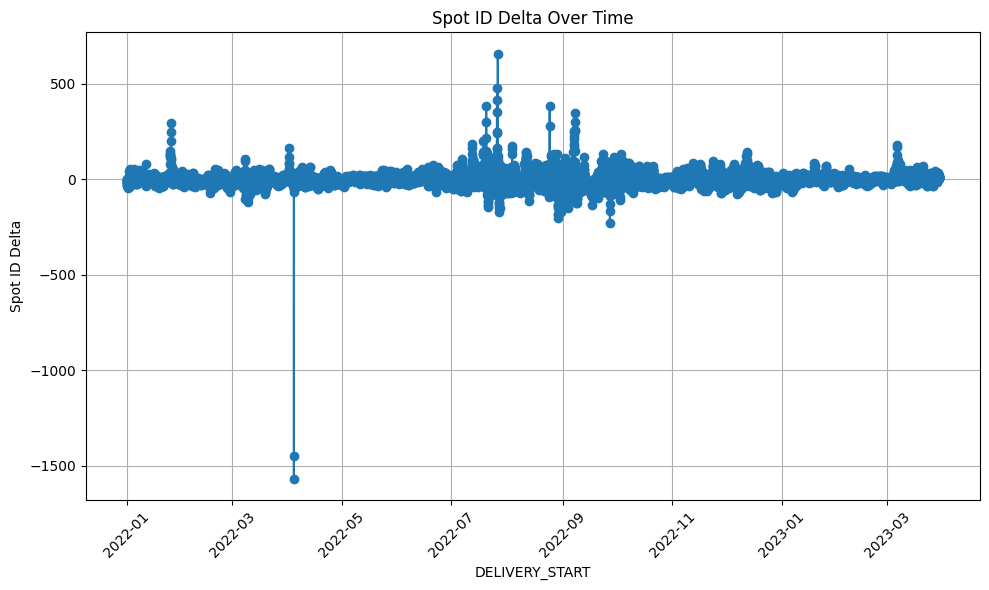

In [155]:
# Assuming your DataFrame is named df
# If it's not, replace df with the name of your DataFrame variable

# Plotting
plt.figure(figsize=(10, 6))  # Set the figure size as desired
#y_train.index = pd.to_datetime(y_train.index)
plt.plot(y_train.index, y_train['spot_id_delta'], marker='o', linestyle='-')
plt.title('Spot ID Delta Over Time')  # Add a title to the plot
plt.xlabel('DELIVERY_START')  # Label for the x-axis
plt.ylabel('Spot ID Delta')  # Label for the y-axis
plt.xticks(rotation=45)  # Rotate x-axis labels for better readability
plt.grid(True)  # Enable grid for better readability
plt.tight_layout()  # Adjust layout to not cut off labels


Let's remove the outliers

In [156]:
rows_to_remove = y_train_preprocessed[(y_train_preprocessed["spot_id_delta"] <= -500) | (y_train_preprocessed["spot_id_delta"] >= 400)]
indices_to_remove = rows_to_remove.index.tolist()

X_train = process_data(X_train_preprocessed.copy(deep=True), "predicted_spot_price", indices_to_remove, "standard")
y_train = process_data(y_train_preprocessed.copy(deep=True), None, indices_to_remove, None)
X_test = process_data(X_test_preprocessed.copy(deep=True), "predicted_spot_price", None, "standard")

Plot again

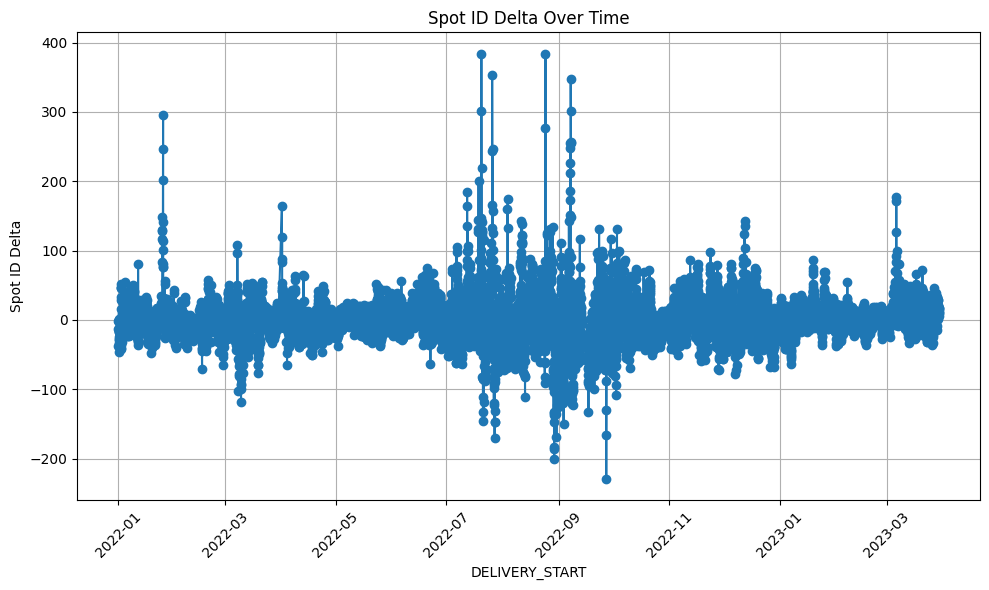

In [157]:


# Assuming your DataFrame is named df
# If it's not, replace df with the name of your DataFrame variable

# Plotting
plt.figure(figsize=(10, 6))  # Set the figure size as desired
#y_train.index = pd.to_datetime(y_train.index)
plt.plot(y_train.index, y_train['spot_id_delta'], marker='o', linestyle='-')
plt.title('Spot ID Delta Over Time')  # Add a title to the plot
plt.xlabel('DELIVERY_START')  # Label for the x-axis
plt.ylabel('Spot ID Delta')  # Label for the y-axis
plt.xticks(rotation=45)  # Rotate x-axis labels for better readability
plt.grid(True)  # Enable grid for better readability
plt.tight_layout()  # Adjust layout to not cut off labels

Doing a LinearRegression with cleaned data

In [158]:

# Initialize Linear Regression model
lr = LinearRegression()

# Initialize Sequential Feature Selector
sfs = SequentialFeatureSelector(lr, n_features_to_select='auto', direction='forward', scoring='neg_mean_squared_error', cv=5)

# Fit SFS on the training data
sfs.fit(X_train, y_train)

# Get the support mask of selected features
selected_features = sfs.get_support()

# Names/indices of the selected features
selected_indices = [i for i, x in enumerate(selected_features) if x]
print("Selected feature indices:", selected_indices)

# Evaluate model performance with selected features
X_train_selected = X_train.loc[:, selected_features]
X_test_selected = X_test.loc[:, selected_features]


lr.fit(X_train_selected, y_train)
y_pred = lr.predict(X_test_selected)
d = {"DELIVERY_START" : delivery_start, "spot_id_delta" : y_pred.reshape(-1)}
y_pred = pd.DataFrame(data = d)

#y_pred.to_csv("../data/y_test_result_LR2.csv", index = False)

Selected feature indices: [0, 4, 6, 7]


Score for y_test_result_LR2 : 0,5301069633020465

Let's do another regression with the scoring advised

In [159]:


# Initialize Linear Regression model
lr = LinearRegression()

# Initialize Sequential Feature Selector
sfs = SequentialFeatureSelector(lr, n_features_to_select='auto', direction='forward', scoring=weighted_accuracy_scorer, cv=5)

# Fit SFS on the training data
sfs.fit(X_train, y_train)

# Get the support mask of selected features
selected_features = sfs.get_support()

# Names/indices of the selected features
selected_indices = [i for i, x in enumerate(selected_features) if x]
print("Selected feature indices:", selected_indices)

# Evaluate model performance with selected features
X_train_selected = X_train.loc[:, selected_features]
X_test_selected = X_test.loc[:, selected_features]


lr.fit(X_train_selected, y_train)
y_pred = lr.predict(X_test_selected)
d = {"DELIVERY_START" : delivery_start, "spot_id_delta" : y_pred.reshape(-1)}
y_pred = pd.DataFrame(data = d)

y_pred.to_csv("../data/y_test_result_LR3.csv", index = False)

Selected feature indices: [0, 1, 3, 6]


Score for y_test_result_LR3 : 0,4801700754952515

# Let's take stock of what's been done

* At this point, we tested a classical linear regression by selecting the most important features. This gave us a score of 0.54. 
* We tried to clean up the data by removing the outliers, but this reduced the score, which tells us that this was not outlier data, but useful information.
* We tried the scoring suggested in the statement, but it gave less good results.

#### Let's continue with this model but try to enrich the data !

In [165]:
X_train_preprocessed
pd.to_datetime(X_train_preprocessed['DELIVERY_START'], utc=True)

0       2022-01-01 01:00:00+00:00
1       2022-01-01 02:00:00+00:00
2       2022-01-01 03:00:00+00:00
3       2022-01-01 04:00:00+00:00
4       2022-01-01 05:00:00+00:00
                   ...           
10600   2023-03-29 17:00:00+00:00
10601   2023-03-29 18:00:00+00:00
10602   2023-03-29 19:00:00+00:00
10603   2023-03-29 20:00:00+00:00
10604   2023-03-29 21:00:00+00:00
Name: DELIVERY_START, Length: 10605, dtype: datetime64[ns, UTC]

In [172]:
cold_rate = {
    1: 100,  # January
    2: 90,   # February
    3: 70,   # March
    4: 50,   # April
    5: 30,   # May
    6: 10,   # June
    7: 0,    # July
    8: 5,    # August
    9: 20,   # September
    10: 40,  # October
    11: 60,  # November
    12: 80   # December
}

X_train_preprocessed['DELIVERY_START'] = pd.to_datetime(X_train_preprocessed['DELIVERY_START'])
X_test_preprocessed['DELIVERY_START'] = pd.to_datetime(X_test_preprocessed['DELIVERY_START'])

X_train_preprocessed['month'] = X_train_preprocessed['DELIVERY_START'].dt.month
X_train_preprocessed['cold_rate'] = X_train_preprocessed['month'].map(cold_rate)
X_train_preprocessed.drop('month', axis=1, inplace=True)
X_test_preprocessed['month'] = X_test_preprocessed['DELIVERY_START'].dt.month
X_test_preprocessed['cold_rate'] = X_test_preprocessed['month'].map(cold_rate)
X_test_preprocessed.drop('month', axis=1, inplace=True)

X_train_preprocessed

,DELIVERY_START,load_forecast,coal_power_available,gas_power_available,nucelear_power_available,wind_power_forecasts_average,solar_power_forecasts_average,wind_power_forecasts_std,solar_power_forecasts_std,predicted_spot_price,cold_rate
0,2022-01-01 01:00:00+00:00,49439.0,3386.0,11487.0,44118.0,3035.0,0.0,79.248348,0.000000,NaN,100
1,2022-01-01 02:00:00+00:00,46511.0,3386.0,11487.0,44118.0,3143.0,0.0,61.776532,0.000000,NaN,100
2,2022-01-01 03:00:00+00:00,45158.0,3386.0,11487.0,44118.0,3288.0,0.0,44.291112,0.000000,NaN,100
3,2022-01-01 04:00:00+00:00,44779.0,3386.0,11487.0,44118.0,3447.0,0.0,36.127588,0.000000,NaN,100
4,2022-01-01 05:00:00+00:00,45284.0,3386.0,11487.0,44118.0,3679.0,0.0,30.983023,0.000000,NaN,100
...,...,...,...,...,...,...,...,...,...,...,...
10600,2023-03-29 17:00:00+00:00,50814.0,3386.0,11952.0,38320.0,7552.0,651.0,247.408490,7.821622,108.11,70
10601,2023-03-29 18:00:00+00:00,50628.0,3386.0,11952.0,38320.0,8338.0,109.0,155.795012,2.534054,125.66,70
10602,2023-03-29 19:00:00+00:00,48201.0,3386.0,11952.0,38320.0,9115.0,0.0,126.884684,0.000000,138.01,70
10603,2023-03-29 20:00:00+00:00,47967.0,3386.0,11952.0,38320.0,9636.0,0.0,156.669189,0.000000,136.74,70


In [171]:
X_train = process_data(X_train_preprocessed.copy(deep=True), "predicted_spot_price", None, "standard")
X_test = process_data(X_test_preprocessed.copy(deep=True), "predicted_spot_price", None, "standard")
y_train = process_data(y_train_preprocessed.copy(deep=True), None, None, None)
X_train

,load_forecast,coal_power_available,gas_power_available,nucelear_power_available,wind_power_forecasts_average,solar_power_forecasts_average,wind_power_forecasts_std,solar_power_forecasts_std,cold_rate
DELIVERY_START,,,,,,,,,
2022-01-01 01:00:00+00:00,-0.405599,1.143744,0.049156,1.145111,-0.441788,-0.709854,-0.349637,-0.580887,1.347889
2022-01-01 02:00:00+00:00,-0.682678,1.143744,0.049156,1.145111,-0.409506,-0.709854,-0.482002,-0.580887,1.347889
2022-01-01 03:00:00+00:00,-0.810713,1.143744,0.049156,1.145111,-0.366164,-0.709854,-0.614471,-0.580887,1.347889
2022-01-01 04:00:00+00:00,-0.846578,1.143744,0.049156,1.145111,-0.318637,-0.709854,-0.676317,-0.580887,1.347889
2022-01-01 05:00:00+00:00,-0.798790,1.143744,0.049156,1.145111,-0.249289,-0.709854,-0.715292,-0.580887,1.347889
...,...,...,...,...,...,...,...,...,...
2023-03-29 17:00:00+00:00,-0.275482,1.143744,1.010389,0.384129,0.908396,-0.469079,0.924332,-0.399128,0.465866
2023-03-29 18:00:00+00:00,-0.293084,1.143744,1.010389,0.384129,1.143341,-0.669539,0.230275,-0.522000,0.465866
2023-03-29 19:00:00+00:00,-0.522752,1.143744,1.010389,0.384129,1.375595,-0.709854,0.011252,-0.580887,0.465866


In [173]:
# Initialize Linear Regression model
lr = LinearRegression()

# Initialize Sequential Feature Selector
sfs = SequentialFeatureSelector(lr, n_features_to_select='auto', direction='forward', scoring='neg_mean_squared_error', cv=5)

# Fit SFS on the training data
sfs.fit(X_train, y_train)

# Get the support mask of selected features
selected_features = sfs.get_support()

# Names/indices of the selected features
selected_indices = [i for i, x in enumerate(selected_features) if x]
print("Selected feature indices:", selected_indices)

# Evaluate model performance with selected features
X_train_selected = X_train.loc[:, selected_features]
X_test_selected = X_test.loc[:, selected_features]


lr.fit(X_train_selected, y_train)
y_pred = lr.predict(X_test_selected)
d = {"DELIVERY_START" : delivery_start, "spot_id_delta" : y_pred.reshape(-1)}
y_pred = pd.DataFrame(data = d)

y_pred.to_csv("../data/y_test_result_LR4.csv", index = False)

Selected feature indices: [4, 6, 7, 8]


In [ ]:
"""

X_train = X_train.drop(columns=['DELIVERY_START'])
y_train = y_train.drop(columns=['DELIVERY_START'])

# Convertir X_train en numpy array si ce n'est pas déjà fait (et supposer que cela n'a pas encore été fait)
X_train_values = X_train.values  # Assurez-vous que X_train est un DataFrame avant cette étape

# Redimensionner X_train pour avoir une forme 3D [échantillons, pas de temps, caractéristiques]
# Supposons que chaque échantillon est basé sur une seule période de temps
X_train = X_train_values.reshape((X_train_values.shape[0], 1, X_train_values.shape[1]))

input_shape = (X_train.shape[1], X_train.shape[2])
output_shape = 1

# Création du modèle
model = Sequential([
    GRU(128, input_shape=input_shape, return_sequences=True),
    Dropout(0.5),  # Taux élevé de dropout pour éviter le surapprentissage
    GRU(64, return_sequences=False),
    Dropout(0.5),  # Encore du dropout
    Dense(output_shape, activation='linear')  # 'linear' pour régression, 'sigmoid' pour classification binaire
])

# Compilation du modèle
model.compile(optimizer=Adam(learning_rate=0.001), loss='mean_squared_error')  # 'mean_squared_error' pour régression, 'binary_crossentropy' pour classification

# Résumé du modèle
model.summary()

# Entraînement du modèle
history = model.fit(X_train, y_train, epochs=50, batch_size=64, validation_split=0.2, verbose=1)"""


"\n\nX_train = X_train.drop(columns=['DELIVERY_START'])\ny_train = y_train.drop(columns=['DELIVERY_START'])\n\n# Convertir X_train en numpy array si ce n'est pas déjà fait (et supposer que cela n'a pas encore été fait)\nX_train_values = X_train.values  # Assurez-vous que X_train est un DataFrame avant cette étape\n\n# Redimensionner X_train pour avoir une forme 3D [échantillons, pas de temps, caractéristiques]\n# Supposons que chaque échantillon est basé sur une seule période de temps\nX_train = X_train_values.reshape((X_train_values.shape[0], 1, X_train_values.shape[1]))\n\ninput_shape = (X_train.shape[1], X_train.shape[2])\noutput_shape = 1\n\n# Création du modèle\nmodel = Sequential([\n    GRU(128, input_shape=input_shape, return_sequences=True),\n    Dropout(0.5),  # Taux élevé de dropout pour éviter le surapprentissage\n    GRU(64, return_sequences=False),\n    Dropout(0.5),  # Encore du dropout\n    Dense(output_shape, activation='linear')  # 'linear' pour régression, 'sigmoid' p

In [ ]:
"""

# Supposons que X_train et y_train sont déjà préparés et adaptés pour l'entraînement
# X_train = X_train.drop(columns=['DELIVERY_START'])
# y_train = y_train.drop(columns=['DELIVERY_START'])

# Dimensions de vos données
# Remarque : Assurez-vous que X_train est formaté correctement pour GRU ([échantillons, pas de temps, caractéristiques])

X_train = X_train.drop(columns=['DELIVERY_START'])
y_train = y_train.drop(columns=['DELIVERY_START'])

# Convertir X_train en numpy array si ce n'est pas déjà fait (et supposer que cela n'a pas encore été fait)
X_train_values = X_train.values  # Assurez-vous que X_train est un DataFrame avant cette étape

# Redimensionner X_train pour avoir une forme 3D [échantillons, pas de temps, caractéristiques]
# Supposons que chaque échantillon est basé sur une seule période de temps
X_train = X_train_values.reshape((X_train_values.shape[0], 1, X_train_values.shape[1]))

input_shape = (X_train.shape[1], X_train.shape[2])

# Création du modèle avec une structure potentiellement plus complexe pour capturer plus de nuances dans les données
model = Sequential([
    GRU(8, input_shape=input_shape, return_sequences=True),
    Dropout(0.3),  # Réduction du dropout pour équilibrer régularisation et capacité d'apprentissage
    GRU(16, return_sequences=True),
    Dropout(0.3),
    GRU(8, return_sequences=False),
    Dropout(0.3),
    Dense(1, activation='linear')  # 'linear' pour régression
])

# Compilation du modèle avec un taux d'apprentissage initial potentiellement plus élevé
optimizer = Adam(learning_rate=0.001)
model.compile(optimizer=optimizer, loss='mean_squared_error')

# Résumé du modèle
model.summary()

# Callbacks pour ajuster le taux d'apprentissage et arrêter l'entraînement prématurément si nécessaire
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=0.0001)

# Entraînement du modèle avec validation_split pour surveiller la overfitting
history = model.fit(X_train, y_train, epochs=100, batch_size=64, validation_split=0.2, verbose=1, callbacks=[early_stopping, reduce_lr])"""


"\n\n# Supposons que X_train et y_train sont déjà préparés et adaptés pour l'entraînement\n# X_train = X_train.drop(columns=['DELIVERY_START'])\n# y_train = y_train.drop(columns=['DELIVERY_START'])\n\n# Dimensions de vos données\n# Remarque : Assurez-vous que X_train est formaté correctement pour GRU ([échantillons, pas de temps, caractéristiques])\n\nX_train = X_train.drop(columns=['DELIVERY_START'])\ny_train = y_train.drop(columns=['DELIVERY_START'])\n\n# Convertir X_train en numpy array si ce n'est pas déjà fait (et supposer que cela n'a pas encore été fait)\nX_train_values = X_train.values  # Assurez-vous que X_train est un DataFrame avant cette étape\n\n# Redimensionner X_train pour avoir une forme 3D [échantillons, pas de temps, caractéristiques]\n# Supposons que chaque échantillon est basé sur une seule période de temps\nX_train = X_train_values.reshape((X_train_values.shape[0], 1, X_train_values.shape[1]))\n\ninput_shape = (X_train.shape[1], X_train.shape[2])\n\n# Création du m